NOTES:
Essayer de voir les données corrélées entre elles en utilisant VIF par exemple pour supprimer des features et améliorer l apprentissage
Possibilité aussi de faire du sur ou sous échantillonage ou d'utiliser SMOTE 

In [1]:
import sys
import os

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from wordcloud import WordCloud


# Ajouter le chemin du dossier contenant nos classes
sys.path.append(os.path.abspath(os.path.join('.', 'classes')))


from language_tools import TextProcessing

2024-12-19 09:08:46.296262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 09:08:46.309548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 09:08:46.312936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 09:08:46.322306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 09:08:46.922529: W tensorflow/compiler/tf2

In [2]:
# Test si GPU reconnu
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1734595728.139153   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734595728.163732   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734595728.167536   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## 1. Chargement des données

In [3]:
# Load dataset
raw_data = pd.read_csv('./data/spam.csv', encoding='iso-8859-1')
raw_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 2. Analyse exploratoire


In [4]:
# Basic stats
print("Taille du dataset:")
print("Number of rows : {}".format(raw_data.shape[0]))
print("Number of columns : {}".format(raw_data.shape[1]))
print()
print("---------------------------")
print()

print("Dataset:")
print()
display(raw_data.head())
print()
print("---------------------------")

print("Basics infos:")
print()
display(raw_data.info())
print()
print("---------------------------")
print()

print("Basics statistics: ")
print()
data_desc = raw_data.describe(include='all')
display(data_desc)
print()
print("---------------------------")
print()

print("Unique elements by feature: ")
print()
display(raw_data.nunique().sort_values())
print()
print("---------------------------")
print()

print("Percentage of missing values: ")
print()
display(100*raw_data.isnull().sum()/raw_data.shape[0])

Taille du dataset:
Number of rows : 5572
Number of columns : 5

---------------------------

Dataset:



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



---------------------------
Basics infos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


None


---------------------------

Basics statistics: 



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



---------------------------

Unique elements by feature: 



v1               2
Unnamed: 4       5
Unnamed: 3      10
Unnamed: 2      43
v2            5169
dtype: int64


---------------------------

Percentage of missing values: 



v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

Le dataset est composé de 5 colonnes.

On ne voit pas de valeurs nulles sur les 2 premières colonnes.

Les 3 dernières colonnes ont 99% de valeurs nulles.

### A qui correspondent les colonnes `Unnamed: x` ?

In [5]:
raw_data[raw_data['Unnamed: 2'].str.len() > 0].head(7)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""


Il est probable que les colonnes supplémentaires soit la suite du message de la colonne `v2` dû à un problème de formatage.

Je vais prendre le parti de fusionner les textes de ces colonnes.

### Répartition des spams

In [6]:
spam_distribution = raw_data.groupby('v1').size().reset_index(name='count')

# Calculer le total des messages
total_messages = spam_distribution['count'].sum()

# Calculer le pourcentage de chaque type de message
spam_distribution['percentage'] = (spam_distribution['count'] / total_messages) * 100

fig = px.bar(spam_distribution, 
            x='v1', 
            y='percentage',
            title='Répartition des messages Spam ou non',
            labels={'v1': 'Type de message', 'percentage': 'Pourcentage'},
            width=1024,
            height= 680,
            color='percentage',
            color_continuous_scale=px.colors.sequential.Viridis,
            text='percentage'
)

# Mettre en forme les annotations
fig.update_traces(texttemplate='%{text:.2f}%')

fig.show()

Nous avons un dataset assez déséquilibré avec un peu plus de 13% de messages étant des spams.

## 3. Nettoyage et pré-traitement des données

Nous allons en premier, préparer le texte  pour qu'il soit interprétable par les modèles.

Création d'un nouveau dataset avec les colonnes fusionnées.

Passage de la colonne spam avec des valeurs de type Integer pour la compréhension des valeurs par les modèles.

In [7]:
data = pd.DataFrame()
data['spam'] =  raw_data['v1'].apply(lambda x: 1 if x == 'spam' else 0)
data['message'] = raw_data.iloc[:, 1:].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
display(data)

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


Pré traitement du texte :

In [8]:
test_tp = "URGENT! Your Mobile number has been awarded :) a <UKP>2000 prize GUARANTEED. Call 09061790125 from landline. Claim 3030. Valid 12hrs only 150ppm"

print(test_tp)

text_processing = TextProcessing()
test_tp = text_processing.standardize(test_tp)

print(test_tp)

URGENT! Your Mobile number has been awarded :) a <UKP>2000 prize GUARANTEED. Call 09061790125 from landline. Claim 3030. Valid 12hrs only 150ppm
urgent your mobile number has been awarded EMOJIsmile a 2000 prize guaranteed call 09061790125 from landline claim 3030 valid 12hrs only 150ppm


Création d'un nouvelle colonne avec le texte nettoyé.

In [9]:
data['preprocessed_message'] = data['message'].apply(text_processing.standardize)

Ajout d'une colonne contenant la taille de la colonne preprocessed_message.

In [10]:
data['len'] = data['preprocessed_message'].apply(lambda x: len(x))

In [11]:
max_sentence_len = data.len.max()
print(f"Max chars for preprocess column: {max_sentence_len}")

Max chars for preprocess column: 888


In [12]:
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

nlp = en_core_web_sm.load()


In [13]:
data["preprocessed_lematized"] = data['preprocessed_message'].apply(lambda x: text_processing.lemmatize(x, nlp))
data['lematized_len'] = data['preprocessed_lematized'].apply(lambda x: len(x))
display(data)

,spam,message,preprocessed_message,len,preprocessed_lematized,lematized_len
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,102,go until jurong point crazy available only in ...,102
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,23,ok lar joke wif u oni,21
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,149,free entry in 2 a wkly comp to win fa cup fina...,149
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,43,u dun say so early hor u c already then say,43
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,59,nah I do not think he go to usf he live around...,58
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,153,this be the 2nd time we have try 2 contact u u...,151
5568,0,Will Ì_ b going to esplanade fr home?,will ì b going to esplanade fr home,35,will ì b go to esplanade fr home,32
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that soany other suggest...,50,pity be in mood for that soany other suggestion,49
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like id ...,124,the guy do some bitching but I act like i d be...,119


In [14]:
## Tokenize the cleaned document
tokenized_doc = data['preprocessed_lematized'].fillna('').apply(lambda x: nlp(x))

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_doc

0       [jurong, point, crazy, available, bugis, n, gr...
1                            [ok, lar, joke, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3                              [u, dun, early, hor, u, c]
4                              [nah, I, think, usf, live]
                              ...                        
5567    [2nd, time, try, 2, contact, u, u, win, å£750,...
5568                          [ì, b, esplanade, fr, home]
5569                  [pity,   , mood, soany, suggestion]
5570    [guy, bitching, I, act, like, d, interested, b...
5571                                         [rofl, true]
Name: preprocessed_lematized, Length: 5572, dtype: object

In [15]:
# add a clean token column 
data["clean_token"] = [" ".join(x) for x in tokenized_doc]
data['clean_token_len'] = data['clean_token'].apply(lambda x: len(x))
data.head()

,spam,message,preprocessed_message,len,preprocessed_lematized,lematized_len,clean_token,clean_token_len
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,102,go until jurong point crazy available only in ...,102,jurong point crazy available bugis n great wor...,75
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,23,ok lar joke wif u oni,21,ok lar joke wif u oni,21
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,149,free entry in 2 a wkly comp to win fa cup fina...,149,free entry 2 wkly comp win fa cup final tkts 2...,131
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,43,u dun say so early hor u c already then say,43,u dun early hor u c,19
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,59,nah I do not think he go to usf he live around...,58,nah I think usf live,20


In [16]:
fig = px.histogram(data, x='lematized_len', nbins=50, title='Distribution des longueurs des messages', histnorm='density', marginal="box")
fig.show()


In [17]:
data['clean_token'] = data['clean_token'].str.slice(0, 115)

data["clean_token"].str.len().max()

115

## 4. vectorisation des textes

Nous allons dans un premier temps utiliser un modèle simple de régression qui nous servira de référence.

**CountVectorizer** convertit du texte en vecteurs de longueur fixe en comptant combien de fois chaque mot apparaît. Les tokens sont maintenant stockés sous forme de sac de mots.


**TfidVectorizer** TF-IDF prend également en compte l'importance des mots.

In [18]:
# TF-IDF vector
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

X = vectorizer_tfidf.fit_transform(data['clean_token'])
y = data["spam"]

# X is a generator. We can transform that as an array
dense = X.toarray()
dense[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
tfidf_nb_features = vectorizer_tfidf.get_feature_names_out()
print("[INFO] : Nombre de features dans le vocabulaire : ", len(tfidf_nb_features))

[INFO] : Nombre de features dans le vocabulaire :  8120


In [20]:
# Diviser les données en ensemble d'entraînement et de test, stratify car la cible est très déséquilibrée
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
vocabulary = vectorizer_tfidf.vocabulary_
vocabulary

{'jurong': 4089,
 'point': 5600,
 'crazy': 2221,
 'available': 1308,
 'bugis': 1706,
 'great': 3405,
 'world': 7869,
 'la': 4233,
 'buffet': 1704,
 'cine': 1991,
 'amore': 1116,
 'wat': 7679,
 'ok': 5222,
 'lar': 4265,
 'joke': 4055,
 'wif': 7782,
 'oni': 5252,
 'free': 3132,
 'entry': 2807,
 'wkly': 7830,
 'comp': 2089,
 'win': 7795,
 'fa': 2919,
 'cup': 2267,
 'final': 3014,
 'tkts': 7188,
 '21st': 459,
 '2005': 448,
 'text': 7055,
 '87121': 852,
 'receive': 5934,
 'questionstd': 5844,
 'txt': 7372,
 'ratetcs': 5890,
 'apply': 1189,
 '08': 48,
 'dun': 2673,
 'early': 2690,
 'hor': 3681,
 'nah': 4928,
 'think': 7116,
 'usf': 7505,
 'live': 4385,
 'freemsg': 3140,
 'hey': 3590,
 'darle': 2331,
 'week': 7719,
 'word': 7858,
 'like': 4352,
 'fun': 3197,
 'tb': 6993,
 'xxx': 7987,
 'std': 6735,
 'chgs': 1941,
 'send': 6300,
 '150': 360,
 'rcv': 5900,
 'brother': 1678,
 'speak': 6632,
 'treat': 7307,
 'aids': 1050,
 'patent': 5422,
 'request': 6020,
 'melle': 4669,
 'oru': 5307,
 'minnamin

In [22]:
vocabulary_df = pd.DataFrame(list(vocabulary.items()), columns=['word', 'count'])
vocabulary_df = vocabulary_df.sort_values(by=['count'], ascending=False)
display(vocabulary_df)


,word,count
6779,ûówell,8119
2039,ûò,8118
3360,ûïharry,8117
5364,ûªve,8116
5478,ûªt,8115
...,...,...
4752,01223585334,4
6081,01223585236,3
8021,0121,2
3930,0089my,1


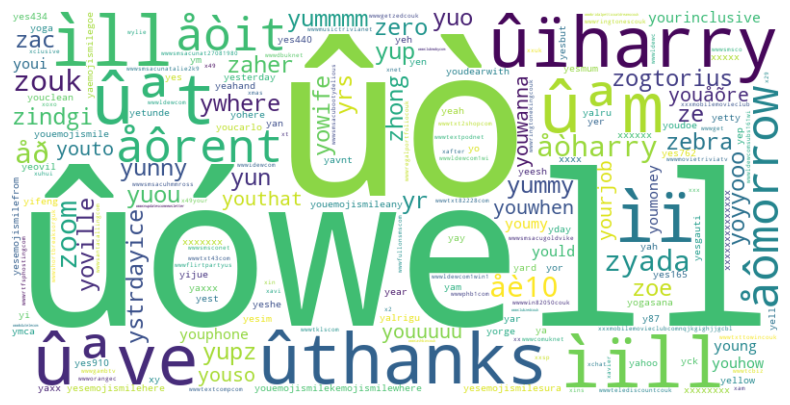

In [23]:
# Filtrer les mots avec des fréquences valides
word_freq = {word: float(freq) for word, freq in vocabulary.items() if isinstance(freq, (int, float))}

# Générer le nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 5. Entrainement des modèles

### 5.1 Machine learning

#### 5.1.1 Regression logistique

Utilisation d'un modèle de régression logistique simple pour avoir un premier modèle de base.

In [24]:
# C représente l'inverse de la régularisation, plus C est grand moins on régularise.
model_lr = LogisticRegression(C=12, n_jobs=-1)
model_lr.fit(X_train, y_train)

# Prédire les labels sur l'ensemble de test
y_pred_lr = model_lr.predict(X_test)

# Afficher les résultats
print(f"Accuracy: { round(accuracy_score(y_test, y_pred_lr), 2) }%")
print('---')
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.98%
---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



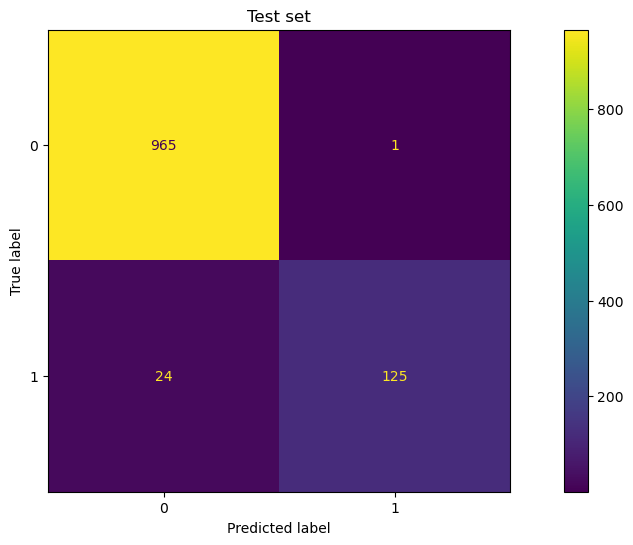

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

La performance de ce modèle est plutôt bonne mais pas assez efficace sur la prédiction des SPAMs, il en a en effet pas détecté 39 sur 150. Par contre point très positif, le modèle ne s'est trompé qu'une seule fois sur les messages non SPAMs.

In [26]:
importance_list = model_lr.coef_[0]

# Transform the list and features names in Pandas dataframe
importance_df = pd.DataFrame(list(zip(tfidf_nb_features, importance_list)),
               columns =['word', 'importance']).sort_values(by=['importance'], ascending=False)

# Display the dataframe
importance_df.head(20)

,word,importance
7372,txt,9.626404
1997,claim,8.048047
6321,service,7.435404
7795,win,7.120737
6013,reply,6.307407
7484,urgent,5.490605
7236,tone,5.482683
4790,mobile,5.349841
675,500,5.176203
6768,stop,5.164224


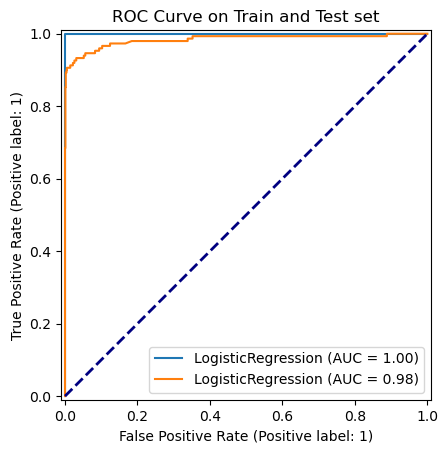

In [27]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train and Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    model_lr, X_train, y_train, ax=ax
)  # RocCurveDisplay from sklearn
RocCurveDisplay.from_estimator(
    model_lr, X_test, y_test, ax=ax
) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [28]:
# Liste de nouveaux messages à tester, le premier est le seul qui n'est pas un SPAM
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!"
]

# Prétraiter et vectoriser
new_messages_clean = [text_processing.standardize(msg) for msg in new_messages]
new_messages_vector = vectorizer_tfidf.transform(new_messages_clean)

# Prédiction du modèle
predictions = model_lr.predict(new_messages_vector)

# Affichage des résultats
for i, pred in enumerate(predictions):
    print(f"Message: '{new_messages[i]}' -> {pred}")


Message: 'Hey, are you free for lunch tomorrow?' -> 0
Message: 'Congrats! You've won a free trip to Bahamas!' -> 0
Message: 'URGENT! You have 1 hour to claim your prize.' -> 1
Message: 'You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!' -> 0
Message: 'Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.' -> 1
Message: 'You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.' -> 1
Message: 'Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.' -> 0
Message: 'Congratulations! You've been selected to participate in our loyalty program for FREE!' -> 0


#### 5.1.2 Random Forest

Complexifions un peu le modèle en utilisant un Random Forest qui va essayer de trouver des relations plus complexes dans les données.

In [29]:
print("Random Forest grid search...")
classifier_rf = RandomForestClassifier()

# Grid of values to be tested
params_rf = {
    "max_depth": [16, 32, 64, 96, 128, 192, 255],
    "min_samples_split": [2, 4, 8, 10, 12, 16],
    "n_estimators": [4, 8, 16, 32, 48, 64, 96],
}
gridsearch_rf = GridSearchCV(
    classifier_rf, param_grid=params_rf, cv=5, n_jobs=-1
)
gridsearch_rf.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best validation accuracy : ", gridsearch_rf.best_score_)

# Predictions on test set
print("Predictions on test set...")
y_test_rf_pred = gridsearch_rf.predict(X_test)
print("...Done.")
print(y_test_rf_pred)
print()

print(classification_report(y_test, y_test_rf_pred))

Random Forest grid search...


/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



...Done.
Best hyperparameters :  {'max_depth': 96, 'min_samples_split': 12, 'n_estimators': 96}
Best validation accuracy :  0.9768889694151278
Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



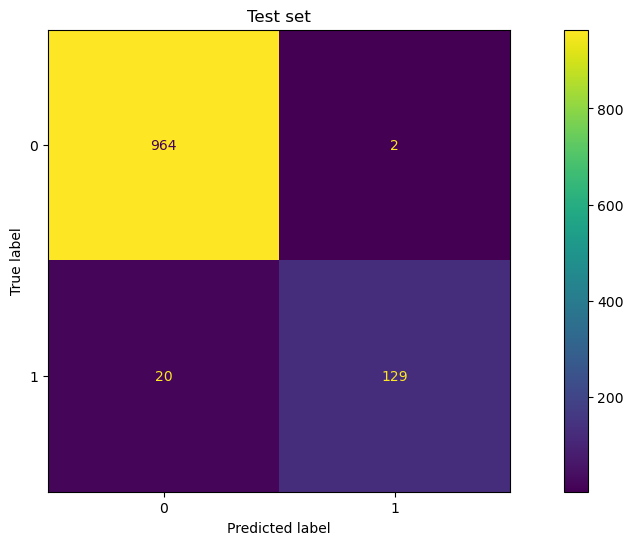

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_rf, X_test, y_test, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

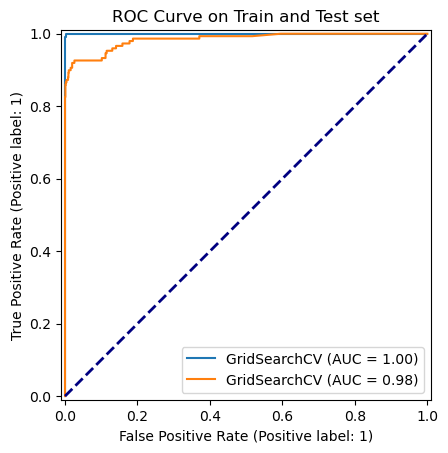

In [31]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train and Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    gridsearch_rf, X_train, y_train, ax=ax
)  # RocCurveDisplay from sklearn
RocCurveDisplay.from_estimator(
    gridsearch_rf, X_test, y_test, ax=ax
) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

Les performances avec Random Forest sont bien meilleurs. Malgré cela le temps d'entrainement et de prédiction a été augmenté et le modèle a prédit 2 SPAMs qui ne devrait pas l'être.

In [32]:
# Liste de nouveaux messages à tester, le premier est le seul qui n'est pas un SPAM
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Prétraiter et vectoriser
new_messages_clean = [text_processing.standardize(msg) for msg in new_messages]
new_messages_vector = vectorizer_tfidf.transform(new_messages_clean)

# Prédiction du modèle
predictions = gridsearch_rf.predict(new_messages_vector)

# Affichage des résultats
for i, pred in enumerate(predictions):
    print(f"Message: '{new_messages[i]}' -> {pred}")

Message: 'Hey, are you free for lunch tomorrow?' -> 0
Message: 'Congrats! You've won a free trip to Bahamas!' -> 0
Message: 'URGENT! You have 1 hour to claim your prize.' -> 1
Message: 'You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!' -> 1
Message: 'Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.' -> 1
Message: 'You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.' -> 1
Message: 'Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.' -> 0
Message: 'Congratulations! You've been selected to participate in our loyalty program for FREE!' -> 0
Message: 'You've been selected to receive an emergency car kit - a must-have for safety on the ro

### 5.3 Deep learning

#### 5.3.1 Préparer les données

In [33]:
# Utiliser les messages prétraités et lemmatisés
X = data['preprocessed_lematized']
y = data['spam']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### 5.3.2 Tokeniser les messages

In [34]:
# Tokeniser les messages (séparer en mots)
from collections import Counter


tokenized_messages = [message.split() for message in data['preprocessed_message']]

# Compter la fréquence des mots
all_tokens = [token for message in tokenized_messages for token in message]
word_counts = Counter(all_tokens)

# Calculer la fréquence cumulée des mots
total_word_count = sum(word_counts.values())
cumulative_count = 0
max_tokens = 0

# Choisir un seuil qui couvre 95% des occurrences
for word, count in word_counts.most_common():
    cumulative_count += count
    max_tokens += 1
    if cumulative_count >= 0.95 * total_word_count:
        break


print(f'Nombre de mots couvrant 95% des occurrences : {max_tokens}')

max_len = int(np.percentile(data['lematized_len'], 95))
print(f'Longueur des séquences max couvrant 95% des occurences: { max_len }')

Nombre de mots couvrant 95% des occurrences : 5490
Longueur des séquences max couvrant 95% des occurences: 153


In [35]:
# Création du TextVectorization layer

# TextVectorization (Tokenizer étant déprécié) : 
# Cette couche remplace le Tokenizer et pad_sequences. 
# Elle prend en entrée des chaînes de caractères et les transforme en séquences d'entiers en une seule étape.

# vocabulary: padding token ('') and OOV token ('[UNK]')

vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)

# vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode='tf_idf', pad_to_max_tokens=True)

# Adapter le vectorizer sur l'ensemble d'entraînement
vectorizer.adapt(X_train.tolist()) # adapt à besoin d'une liste de string ou d'un array Numpy

I0000 00:00:1734595867.241999   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734595867.246989   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734595867.250424   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734595867.423785   37090 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

#### 5.3.3 Base Deep Learning Model

On va commencer par entrainer un modèle simple de deep learning sans RNN ou LSTM.

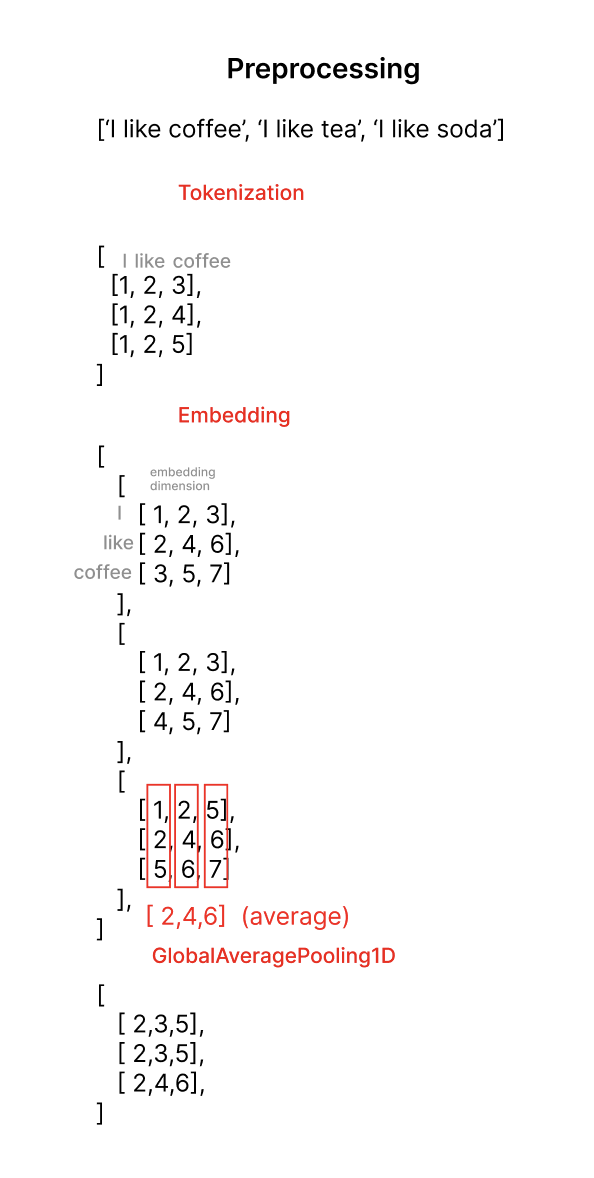

In [36]:
model_deep_base = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens+1, output_dim=64), # Accueille les tokens 1 à 1
    GlobalAveragePooling1D(), # Aggrégation sans tenir compte de l aspect séquentiel
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation="sigmoid") # Classification binaire
])

# Compilation du modèle

model_deep_base.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                                                                                                                    tf.metrics.BinaryAccuracy(),
                                                                                                                    tf.keras.metrics.Precision(name='precision'),
                                                                                                                    tf.keras.metrics.Recall(name='recall')
                                                                                                                  ])


In [37]:
model_deep_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Entraînement
history_deep_base = model_deep_base.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32) # Batch size 

Epoch 1/30


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8365 - loss: 0.4635 - precision: 0.2482 - recall: 0.0842 - val_binary_accuracy: 0.8664 - val_loss: 0.3763 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8724 - loss: 0.3733 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8664 - val_loss: 0.3707 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8612 - loss: 0.3792 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8664 - val_loss: 0.3020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8714 - loss: 0.2701 - precision: 0.3004 - recall: 0.0239 - val_binary_accuracy: 0.9578 - val_loss: 0.1743 - val_precision: 0.8188 - val_recall: 0.8792
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.96

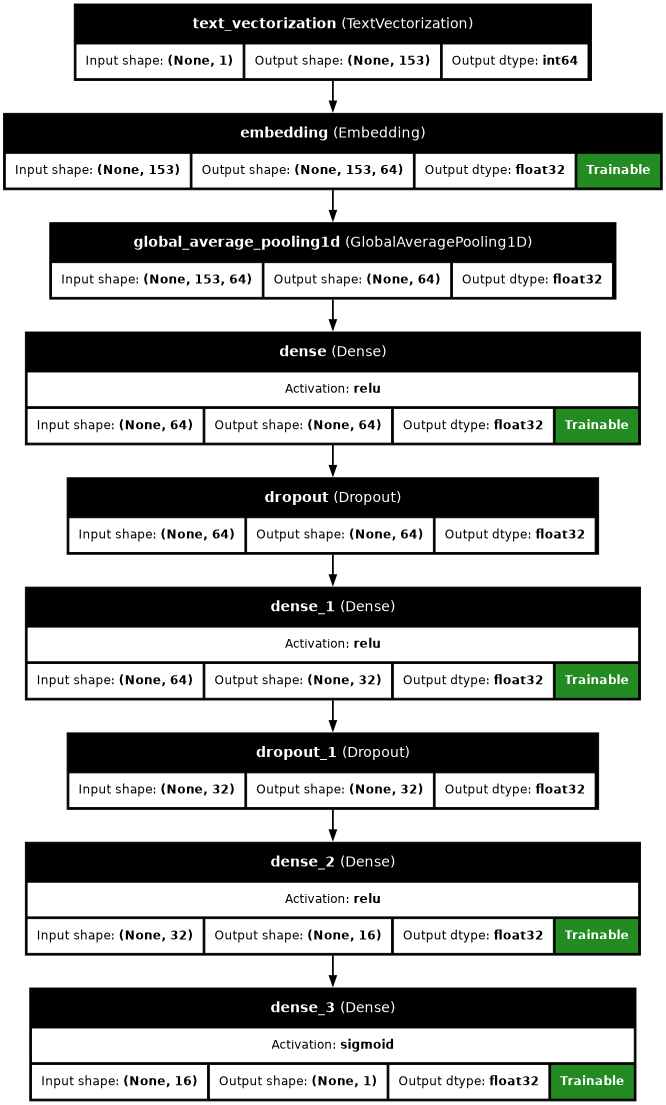

In [39]:
tf.keras.utils.plot_model(model_deep_base, to_file='model_deep_base.png', show_shapes=True, show_layer_names=True, dpi=64, show_layer_activations=True, show_trainable=True, show_dtype=True)

In [40]:
# Prédictions sur l'ensemble de validation
y_pred = (model_deep_base.predict(X_val) > 0.5).astype("int32")

# Rapport de classification
print(classification_report(y_val, y_pred))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.95      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



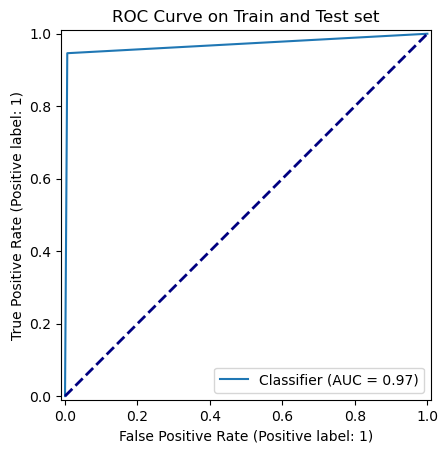

In [41]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train and Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_predictions(
    y_true=y_val, y_pred=y_pred, ax=ax
)  # RocCurveDisplay from sklearn
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

In [42]:
# Extract data from history
history_dict = history_deep_base.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a DataFrame for plotting
epochs = range(1, len(acc) + 1)
df_loss = pd.DataFrame({'Epochs': epochs, 'Training Loss': loss, 'Validation Loss': val_loss})
df_acc = pd.DataFrame({'Epochs': epochs, 'Training Accuracy': acc, 'Validation Accuracy': val_acc})

# Plot loss
fig_loss = px.line(df_loss, x='Epochs', y=['Training Loss', 'Validation Loss'],
                   title='Historique du modèle : Training et Validation Loss',
                   labels={'value': 'Loss', 'variable': 'Type de Loss'})
fig_loss.show()

# Plot accuracy
fig_acc = px.line(df_acc, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
                  title='Historique du modèle : Training et Validation Accuracy',
                  labels={'value': 'Accuracy', 'variable': 'Type d\'Accuracy'})
fig_acc.show()

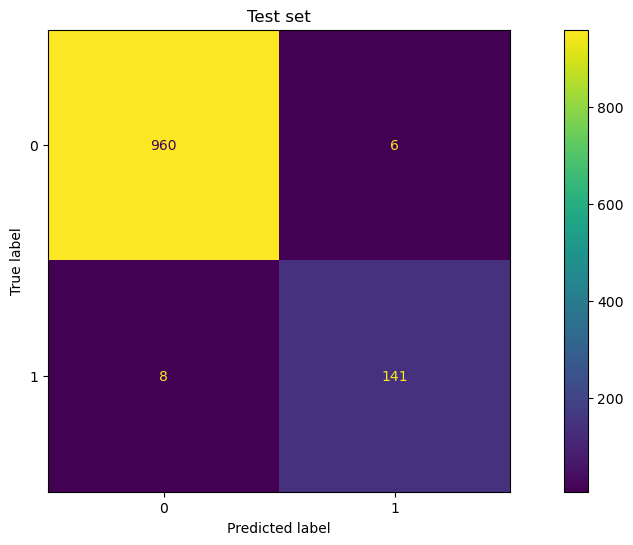

In [43]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

In [44]:
# Liste de nouveaux messages à tester
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Convertir la liste de messages en Series pour l'entrée du modèle
input_series = pd.Series(new_messages)

# Prédire les classes des nouveaux messages
# Le modèle prédit la probabilité, et on considère qu'un message est un spam si la probabilité est supérieure à 0.5
predicted_classes = (model_deep_base.predict(input_series) > 0.5).astype("int32")

# Affichage des résultats
for message, prediction in zip(new_messages, predicted_classes):
    print(f"Message: {message}\nPredicted class: {prediction[0]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Message: Hey, are you free for lunch tomorrow?
Predicted class: 0

Message: Congrats! You've won a free trip to Bahamas!
Predicted class: 1

Message: URGENT! You have 1 hour to claim your prize.
Predicted class: 1

Message: You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!
Predicted class: 1

Message: Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.
Predicted class: 1

Message: You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.
Predicted class: 1

Message: Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.
Predicted class: 1

Message: Congratulations! You've been selected to participate in our l

Le modèle ne parvient pas à identifier correctement les instances positives (classe positive) parmi les prédictions qu'il fait, il probalement généralise trop.
Le modèle s'est amélioré en joant avec le learning rate mais sans être réellement efficace.

Un solution serait peut être d'essayer de faire de l'oversampling sur la classe minoritaire mais d'autres solutions ont bien fonctionné par la suite.

#### 5.3.4 RNN

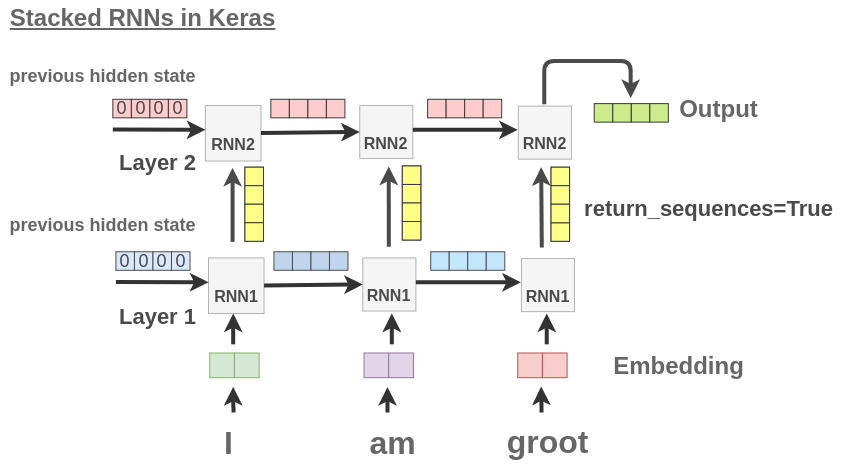

In [45]:
# Construction du modèle RNN
model_rnn = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens+1, output_dim=64),
    SimpleRNN(units=64, return_sequences=True), # maintient la nature séquentielle
    SimpleRNN(units=32, return_sequences=False), # retourne seulement
    Dense(16, activation='relu'), # a dense layer
    Dropout(0.2),
    Dense(8, activation='relu'), # a dense layer
    Dense(1, activation='sigmoid')
])


# Compilation du modèle
model_rnn.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                                                                                                            tf.metrics.BinaryAccuracy(),
                                                                                                            tf.keras.metrics.Precision(name='precision'),
                                                                                                            tf.keras.metrics.Recall(name='recall')
                                                                                                            ])


In [47]:
history_rnn = model_rnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)  # Batch size 

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - binary_accuracy: 0.8350 - loss: 0.4804 - precision: 0.1616 - recall: 0.0284 - val_binary_accuracy: 0.8664 - val_loss: 0.3932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - binary_accuracy: 0.8619 - loss: 0.4218 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8664 - val_loss: 0.3934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - binary_accuracy: 0.8623 - loss: 0.4154 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8664 - val_loss: 0.3934 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - binary_accuracy: 0.8674 - loss: 0.4098 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_binary_accuracy: 0.8664 - val_loss: 0.3935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━

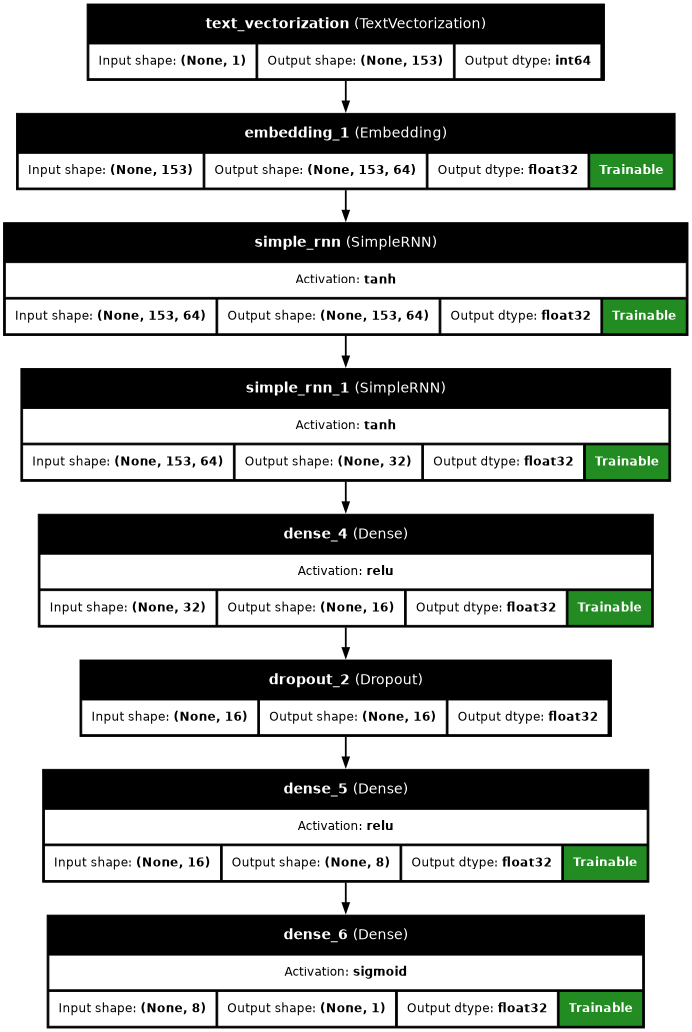

In [48]:
tf.keras.utils.plot_model(model_rnn, to_file='model_rnn.png', show_shapes=True, show_layer_names=True, dpi=64, show_layer_activations=True, show_trainable=True, show_dtype=True)

In [49]:
# Extract data from history
history_dict = history_rnn.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a DataFrame for plotting
epochs = range(1, len(acc) + 1)
df_loss = pd.DataFrame({'Epochs': epochs, 'Training Loss': loss, 'Validation Loss': val_loss})
df_acc = pd.DataFrame({'Epochs': epochs, 'Training Accuracy': acc, 'Validation Accuracy': val_acc})

# Plot loss
fig_loss = px.line(df_loss, x='Epochs', y=['Training Loss', 'Validation Loss'],
                   title='Historique du modèle : Training et Validation Loss',
                   labels={'value': 'Loss', 'variable': 'Type de Loss'})
fig_loss.show()

# Plot accuracy
fig_acc = px.line(df_acc, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
                  title='Historique du modèle : Training et Validation Accuracy',
                  labels={'value': 'Accuracy', 'variable': 'Type d\'Accuracy'})
fig_acc.show()


In [50]:
# Prédictions sur l'ensemble de validation
y_pred = (model_rnn.predict(X_val) > 0.5).astype("int32")

# Rapport de classification
print(classification_report(y_val, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



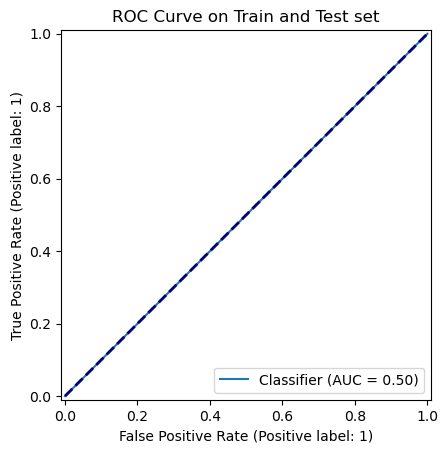

In [51]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train and Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_predictions(
    y_val, y_pred, ax=ax
)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()


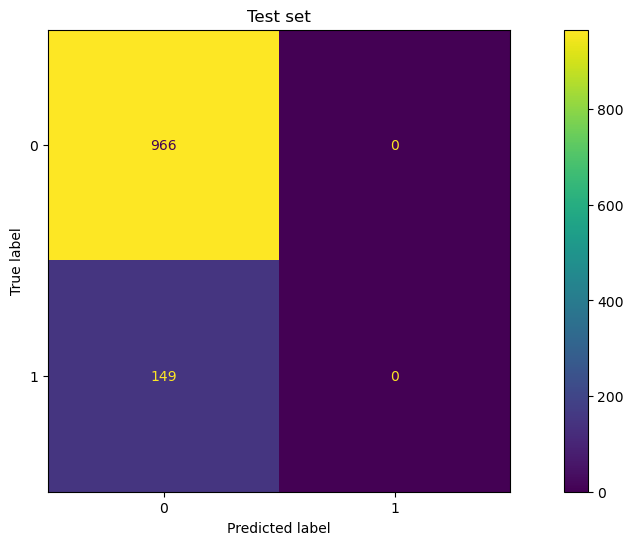

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

In [53]:
# Liste de nouveaux messages à tester
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Convertir la liste de messages en Series pour l'entrée du modèle
input_series = pd.Series(new_messages)

# Prédire les classes des nouveaux messages
# Le modèle prédit la probabilité, et on considère qu'un message est un spam si la probabilité est supérieure à 0.5
predicted_classes = (model_rnn.predict(input_series) > 0.5).astype("int32")

# Affichage des résultats
for message, prediction in zip(new_messages, predicted_classes):
    print(f"Message: {message}\nPredicted class: {prediction[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Message: Hey, are you free for lunch tomorrow?
Predicted class: 0

Message: Congrats! You've won a free trip to Bahamas!
Predicted class: 0

Message: URGENT! You have 1 hour to claim your prize.
Predicted class: 0

Message: You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!
Predicted class: 0

Message: Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.
Predicted class: 0

Message: You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.
Predicted class: 0

Message: Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.
Predicted class: 0

Message: Congratulations! You've been selected to participate in our l

Encore un problème d'underfitting que le modèle de deep learning de base.

#### 5.3.5 LSTM

##### LSTM unidirectionnel

In [54]:
# Construction du modèle RNN
model_lstm = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=64),
    LSTM(units=64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'), # a dense layer
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model_lstm.compile(optimizer=Adam(learning_rate=0.000001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')
                            ])

# Entraînement
history_lstm = model_lstm.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=32)

# Évaluation du modèle
lstm_bi_loss, lstm_bi_acc, lstm_bi_precision, lstm_bi_recall = model_lstm.evaluate(X_val, y_val)
print(f'Test loss: {lstm_bi_loss}')
print(f'Test accuracy: {lstm_bi_acc}')
print(f'Test precision: {lstm_bi_precision}')
print(f'Test recall: {lstm_bi_recall}')

Epoch 1/15
 33/140 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5744 - loss: 0.6929 - precision: 0.0973 - recall: 0.3769

2024-12-19 09:20:03.656820: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6619 - loss: 0.6921 - precision: 0.1181 - recall: 0.2791 - val_accuracy: 0.8664 - val_loss: 0.6893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8616 - loss: 0.6885 - precision: 0.1495 - recall: 0.0141 - val_accuracy: 0.8664 - val_loss: 0.6864 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8667 - loss: 0.6865 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8664 - val_loss: 0.6845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8751 - loss: 0.6845 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8664 - val_loss: 0.6829 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8630 - loss: 0.6835 - precision: 0.0000e+00 - recall: 0.0

In [55]:
# Extract data from history
history_dict = history_lstm.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a DataFrame for plotting
epochs = range(1, len(acc) + 1)
df_loss = pd.DataFrame({'Epochs': epochs, 'Training Loss': loss, 'Validation Loss': val_loss})
df_acc = pd.DataFrame({'Epochs': epochs, 'Training Accuracy': acc, 'Validation Accuracy': val_acc})

# Plot loss
fig_loss = px.line(df_loss, x='Epochs', y=['Training Loss', 'Validation Loss'],
                   title='Historique du modèle : Training et Validation Loss',
                   labels={'value': 'Loss', 'variable': 'Type de Loss'})
fig_loss.show()

# Plot accuracy
fig_acc = px.line(df_acc, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
                  title='Historique du modèle : Training et Validation Accuracy',
                  labels={'value': 'Accuracy', 'variable': 'Type d\'Accuracy'})
fig_acc.show()


In [56]:
# Prédictions sur l'ensemble de validation
y_pred = (model_lstm.predict(X_val) > 0.5).astype("int32")

# Rapport de classification
print(classification_report(y_val, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



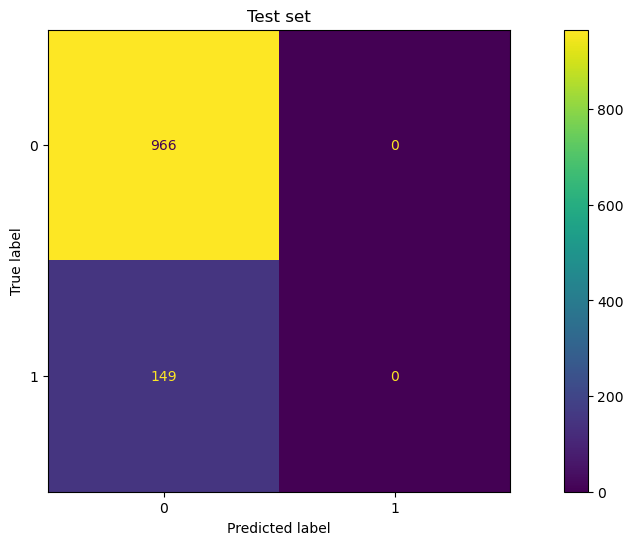

In [57]:
ig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

In [58]:
# Liste de nouveaux messages à tester
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+", # spam
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Convertir la liste de messages en Series pour l'entrée du modèle
input_series = pd.Series(new_messages)

# Prédire les classes des nouveaux messages
# Le modèle prédit la probabilité, et on considère qu'un message est un spam si la probabilité est supérieure à 0.5
predicted_classes = (model_lstm.predict(input_series) > 0.5).astype("int32")

# Affichage des résultats
for message, prediction in zip(new_messages, predicted_classes):
    print(f"Message: {message}\nPredicted class: {prediction[0]}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Message: Hey, are you free for lunch tomorrow?
Predicted class: 0

Message: England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+
Predicted class: 0

Message: Congrats! You've won a free trip to Bahamas!
Predicted class: 0

Message: URGENT! You have 1 hour to claim your prize.
Predicted class: 0

Message: You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!
Predicted class: 0

Message: Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.
Predicted class: 0

Message: You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.
Predicted class: 0

Message: Hello, Your shipment has

Une technique permettant de palier ce problème serait d'essayer de faire de l'oversmapling sur les données minoritaire pour réequilibre la classe.

##### LSTM bidirectionnel

In [59]:
model_bi_lstm = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=64),
    Bidirectional(LSTM(units=64)),  # LSTM bidirectionnelle
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Activation sigmoid pour la classification binaire
])

# Compilation du modèle
model_bi_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall'),
                            ])

# Entraînement
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# # Évaluation du modèle
lstm_bi_loss, lstm_bi_acc, lstm_bi_precision, lstm_bi_recall = model_bi_lstm.evaluate(X_val, y_val)
print(f'Test loss: {lstm_bi_loss}')
print(f'Test accuracy: {lstm_bi_acc}')
print(f'Test precision: {lstm_bi_precision}')
print(f'Test recall: {lstm_bi_recall}')

Epoch 1/50


140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8611 - loss: 0.5778 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8664 - val_loss: 0.3240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8676 - loss: 0.3140 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8664 - val_loss: 0.2504 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8613 - loss: 0.2483 - precision: 0.2837 - recall: 0.0017 - val_accuracy: 0.8691 - val_loss: 0.1844 - val_precision: 1.0000 - val_recall: 0.0201
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8885 - loss: 0.1847 - precision: 0.9336 - recall: 0.1824 - val_accuracy: 0.9605 - val_loss: 0.1568 - val_precision: 0.9907 - val_recall: 0.7114
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9466 - loss: 0.1487 - precision: 0.9899 - recall: 0.6106 - val_accur

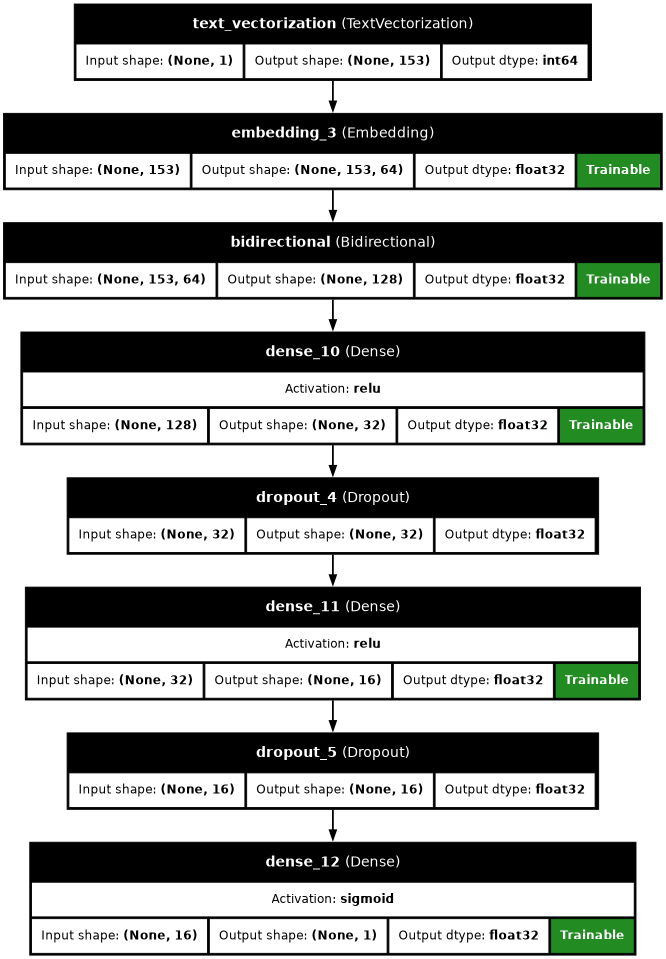

In [60]:
tf.keras.utils.plot_model(model_bi_lstm, to_file='model_bi_lstm.png', show_shapes=True, show_layer_names=True, dpi=64, show_layer_activations=True, show_trainable=True, show_dtype=True)

In [61]:
# Extract data from history
history_dict = history_bi_lstm.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a DataFrame for plotting
epochs = range(1, len(acc) + 1)
df_loss = pd.DataFrame({'Epochs': epochs, 'Training Loss': loss, 'Validation Loss': val_loss})
df_acc = pd.DataFrame({'Epochs': epochs, 'Trainingriable': 'Type d\'Accuracy'})
fig_acc.show()


In [62]:
# Prédictions sur l'ensemble de validation
y_pred = (model_bi_lstm.predict(X_val) > 0.5).astype("int32")

# Rapport de classification
print(classification_report(y_val, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



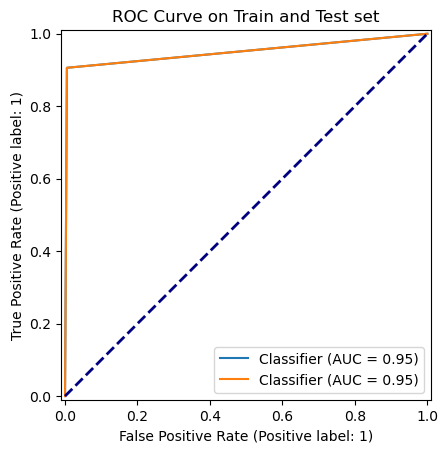

In [63]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train and Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_predictions(
    y_val, y_pred, ax=ax
)  # RocCurveDisplay from sklearn
RocCurveDisplay.from_predictions(
    y_val, y_pred, ax=ax
) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

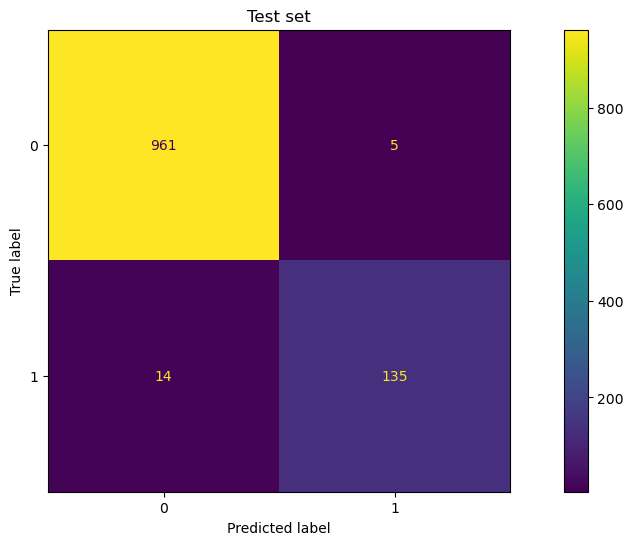

In [64]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

ax1.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax1) # ConfusionMatrixDisplay from sklearn
ax1.set_title('Test set')

plt.show()

In [65]:
# Liste de nouveaux messages à tester
new_messages = [
    "Hey, are you free for lunch tomorrow?", # ham
    "England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+",
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Convertir la liste de messages en Series pour l'entrée du modèle
input_series = pd.Series(new_messages)

# Prédire les classes des nouveaux messages
# Le modèle prédit la probabilité, et on considère qu'un message est un spam si la probabilité est supérieure à 0.5
predicted_classes = (model_bi_lstm.predict(input_series) > 0.5).astype("int32")

# Affichage des résultats
for message, prediction in zip(new_messages, predicted_classes):
    print(f"Message: {message}\nPredicted class: {prediction[0]}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Message: Hey, are you free for lunch tomorrow?
Predicted class: 0

Message: England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+
Predicted class: 1

Message: Congrats! You've won a free trip to Bahamas!
Predicted class: 0

Message: URGENT! You have 1 hour to claim your prize.
Predicted class: 1

Message: You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!
Predicted class: 1

Message: Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.
Predicted class: 1

Message: You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.
Predicted class: 1

Message: Hello, Your shipment has

On voit clairement que le fait de prendre un modèle bidirectionnel permettant au modèle de mieux comprendre le contexte apporte sur les performances du modèle.

Les LSTM bidirectionnelles permettent de capturer le contexte des séquences dans les deux directions (avant et arrière), ce qui est souvent crucial pour des tâches de traitement du langage naturel. En particulier avec des données déséquilibrées, une meilleure compréhension des relations entre les mots dans les deux directions peut améliorer la prédiction des classes minoritaires.

Un LSTM unidirectionnel ne regarde que dans une seule direction (passé ou futur), ce qui peut limiter sa capacité à capturer certains motifs importants dans les séquences de texte, surtout si les indices pertinents pour la classe minoritaire sont dispersés dans la séquence.

#### 5.4 Transfer learning

#### 5.4.1 Bert

BERT signifie Bidirectional Encoder Representations from Transformers. Comme son nom l’indique ce modèle procède de façon bi-directionnel, ce qui lui permet d’avoir une bien meilleure compréhension du texte.

BERT utilise une nouvelle technique appelée Masked LM (MLM) : il masque aléatoirement des mots dans la phrase, puis il essaie de les prédire. 

Le masquage signifie que le modèle regarde dans les deux sens et qu’il utilise le contexte complet de la phrase, à gauche et à droite, afin de prédire le mot masqué.

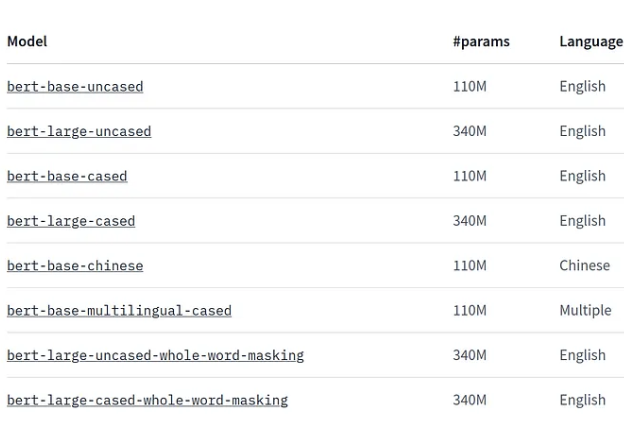

In [66]:
import transformers

print(transformers.__version__)

/home/alexandre/miniforge3/envs/tf-gpu-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



4.45.2


Bert utilise tous les éléments d'une phrase, comme la ponctuation. Nous pouvons donc garder le message brut en entrée.

In [67]:
X = data['message']
y = data['spam']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
model_checkpoint = "distilbert-base-uncased"
batch_size = 32

In [69]:
from transformers import TFAutoModelForSequenceClassification, DistilBertTokenizerFast
from transformers import AdamWeightDecay

# Charger le tokenizer DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def preprocess_data(text_list, max_length=128):
    """
    Fonction qui prend une liste de textes et les prétraite pour les rendre compatibles avec le modèle BERT
    """
    input_ids = []
    attention_masks = []
    for text in text_list:
        encoded_dict = tokenizer(text, 
                                 padding='max_length',  # Padding jusqu'à max_length
                                 truncation=True,       # Tronquer si la séquence est trop longue
                                 max_length=max_length, # Longueur maximale des séquences
                                 return_tensors='tf')
        # Les séquences de tokens et les masques d'attention (indiquant quels tokens doivent être pris en compte)
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return {'input_ids': tf.concat(input_ids, axis=0),
            'attention_mask': tf.concat(attention_masks, axis=0)}

# Charger le modèle de classification avec DistilBERT
model_distilbert = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

# Prétraitement des données d'entraînement et de validation
train_inputs = preprocess_data(X_train, max_length=max_len)
val_inputs = preprocess_data(X_val, max_length=max_len)

# Conversion des labels en tenseurs
train_labels = tf.convert_to_tensor(y_train)
val_labels = tf.convert_to_tensor(y_val)

# Définir l'optimiseur
optimizer = AdamWeightDecay(learning_rate=0.0001)

# Compiler le modèle
model_distilbert.compile(optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Entraînement du modèle
history_bert = model_distilbert.fit(train_inputs, train_labels, 
                               validation_data=(val_inputs, val_labels),
                               batch_size=32, epochs=12)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/12
140/140 [==============================] - 24s 133ms/step - loss: 0.0918 - accuracy: 0.9735 - val_loss: 0.0542 - val_accuracy: 0.9865
Epoch 2/12
140/140 [==============================] - 18s 127ms/step - loss: 0.0316 - accuracy: 0.9933 - val_loss: 0.0548 - val_accuracy: 0.9839
Epoch 3/12
140/140 [==============================] - 18s 130ms/step - loss: 0.0131 - accuracy: 0.9971 - val_loss: 0.0434 - val_accuracy: 0.9919
Epoch 4/12
140/140 [==============================] - 18s 129ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.0490 - val_accuracy: 0.9919
Epoch 5/12
140/140 [==============================] - 18s 129ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.0404 - val_accuracy: 0.9910
Epoch 6/12
140/140 [==============================] - 18s 131ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0585 - val_accuracy: 0.9910
Epoch 7/12
140/140 [==============================] - 18s 129ms/step - loss: 1.3297e-04 - accuracy: 1.0000 - val_loss: 0.0621 - va

35/35 [==============================] - 1s 40ms/step


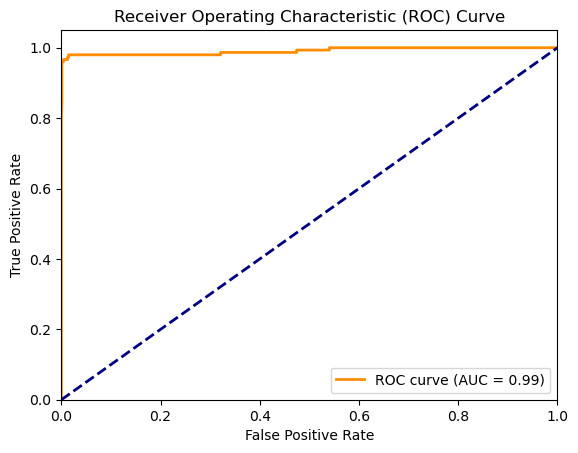

In [70]:
# Prédictions des logits pour l'ensemble de validation
# Les logits sont les valeurs de sortie d'un modèle de classification avant qu'elles ne soient appliquées à une fonction d'activation,
logits = model_distilbert.predict(val_inputs)
# Prédictions sur l'ensemble de validation
outputs = model_distilbert.predict(val_inputs)
logits = outputs.logits


probabilities = tf.sigmoid(logits).numpy()

y_pred_proba = probabilities[:, 0]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(val_labels, y_pred_proba)

# Calcul de l'aire sous la courbe (AUC)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

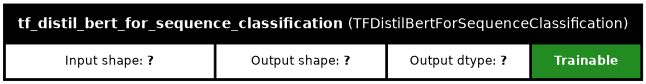

In [71]:
tf.keras.utils.plot_model(model_distilbert, to_file='model_distilbert.png', show_shapes=True, show_layer_names=True, dpi=64, show_layer_activations=True, show_trainable=True, show_dtype=True)

In [72]:
# Prédictions sur l'ensemble de validation
from sklearn.metrics import confusion_matrix


prediction_outputs = model_distilbert.predict(val_inputs)

# Extraction des logits de l'objet de sortie
logits = prediction_outputs.logits

# Transformation des logits en probabilités en utilisant la fonction sigmoïde
probabilities = tf.sigmoid(logits).numpy()

# Conversion des probabilités en prédictions binaires (0 ou 1) en utilisant un seuil de 0.5
y_pred = (probabilities > 0.5).astype("int32")

# Calcul de la matrice de confusion
cm = confusion_matrix(y_val, y_pred)

# Conversion en DataFrame pour l'affichage avec Plotly
cm_df = pd.DataFrame(cm, index=['Non-Spam', 'Spam'], columns=['Prédiction Non-Spam', 'Prédiction Spam'])

# Utilise Plotly pour afficher la matrice de confusion sous forme de heatmap
fig = px.imshow(cm_df,
                text_auto=True,  # Affiche les valeurs dans les cellules
                color_continuous_scale='Blues',  # Utilise une échelle de couleurs bleues
                labels=dict(x="Prédictions", y="Vérité Terrain", color="Nombre"),  # Étiquettes des axes et de la couleur
                title="Matrice de Confusion")  # Titre de la figure

# Afficher la figure
fig.show()

35/35 [==============================] - 1s 38ms/step


In [73]:
# Extract data from history
history_dict = history_bert.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a DataFrame for plotting
epochs = range(1, len(acc) + 1)
df_loss = pd.DataFrame({'Epochs': epochs, 'Training Loss': loss, 'Validation Loss': val_loss})
df_acc = pd.DataFrame({'Epochs': epochs, 'Training Accuracy': acc, 'Validation Accuracy': val_acc})

# Plot loss
fig_loss = px.line(df_loss, x='Epochs', y=['Training Loss', 'Validation Loss'],
                   title='Historique du modèle : Training et Validation Loss',
                   labels={'value': 'Loss', 'variable': 'Type de Loss'})
fig_loss.show()

# Plot accuracy
fig_acc = px.line(df_acc, x='Epochs', y=['Training Accuracy', 'Validation Accuracy'],
                  title='Historique du modèle : Training et Validation Accuracy',
                  labels={'value': 'Accuracy', 'variable': 'Type d\'Accuracy'})
fig_acc.show()


In [74]:
# Nouveaux messages à prédire
new_messages = [
    "Hey, are you free for lunch tomorrow?",  # ham
    "Congrats! You've won a free trip to Bahamas!",
    "URGENT! You have 1 hour to claim your prize.",
    "You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again!",
    "Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize.",
    "You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize.",
    "Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired.",
    "Congratulations! You've been selected to participate in our loyalty program for FREE!",
    "You've been selected to receive an emergency car kit - a must-have for safety on the road! It's quick, easy and 100% FREE."
]

# Prétraiter les nouveaux messages
new_inputs = preprocess_data(new_messages, max_length=128)

# Faire des prédictions
predictions = model_distilbert.predict(new_inputs)

# Convertir les logits en probabilités (avec une sigmoid) et en étiquettes (0 = ham, 1 = spam)
pred_labels = tf.round(tf.nn.sigmoid(predictions.logits))

# Affichage des résultats
for i, message in enumerate(new_messages):
    print(f"Message: {message} --> {int(pred_labels[i])}")


1/1 [==============================] - 1s 692ms/step
Message: Hey, are you free for lunch tomorrow? --> 0
Message: Congrats! You've won a free trip to Bahamas! --> 0
Message: URGENT! You have 1 hour to claim your prize. --> 0
Message: You have (1) parcel awaiting delivery. Track and receive using your code. Plan your delivery and subscribe to our push notifications to prevent this from happening again! --> 1
Message: Congratulations! You've been selected to participate in our loyalty program for FREE! It will only take a minute to receive this fantastic prize. --> 1
Message: You've been selected to participate in our FREE loyalty program! It will only take a minute to receive this fantastic prize. --> 1
Message: Hello, Your shipment has not been collected and has been returned to sender because the collection period has expired. --> 0
Message: Congratulations! You've been selected to participate in our loyalty program for FREE! --> 1
Message: You've been selected to receive an emergenc

In [75]:
# Sauvegarde du modèle
model_distilbert.save_pretrained('./saved/distilbert')

# Sauvegarde du tokenizer
tokenizer.save_pretrained('./saved/distilbert')

# # Recharger le modèle
# model_distilbert = TFAutoModelForSequenceClassification.from_pretrained('./saved/distilbert')

# # Recharger le tokenizer
# tokenizer = DistilBertTokenizerFast.from_pretrained('./saved/distilbert')


('./saved/distilbert/tokenizer_config.json',
 './saved/distilbert/special_tokens_map.json',
 './saved/distilbert/vocab.txt',
 './saved/distilbert/added_tokens.json',
 './saved/distilbert/tokenizer.json')

## 6. Conclusion
